![CMCC](http://cmcc.ufabc.edu.br/images/logo_site.jpg)
# **Modelos de Classificação**

#### Este laboratório irá cobrir os passos para tratar a base de dados de taxa de cliques (click-through rate - CTR) e criar um modelo de classificação para tentar determinar se um usuário irá ou não clicar em um banner.

#### Para isso utilizaremos a base de dados [Criteo Labs](http://labs.criteo.com/) que foi utilizado em uma competição do [Kaggle](https://www.kaggle.com/c/criteo-display-ad-challenge).

#### ** Nesse notebook: **
+  ####*Parte 1:* Utilização do one-hot-encoding (OHE) para transformar atributos categóricos em numéricos
+  ####*Parte 2:* Construindo um dicionário OHE
+  ####*Parte 3:* Geração de atributos OHE na base de dados CTR
 + #### *Visualização 1:* Frequência de atributos
+  ####*Parte 4:* Predição de CTR e avaliação da perda logarítimica (logloss)
 + #### *Visualização 2:* Curva ROC
+  ####*Parte 5:* Reduzindo a dimensão dos atributos através de hashing (feature hashing)
 
#### Referências de métodos: [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)e [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Part 1: Utilização do one-hot-encoding (OHE) para transformar atributos categóricos em numéricos **

#### ** (1a) One-hot-encoding **

#### Para um melhor entendimento do processo da codificação OHE vamos trabalhar com uma base de dados pequena e sem rótulos. Cada objeto dessa base pode conter três atributos, o primeiro indicando o animal, o segundo a cor e o terceiro qual animal que ele come.

#### No esquema OHE, queremos representar cada tupla `(IDatributo, categoria)` através de um atributo binário. Nós podemos fazer isso no Python criando um dicionário que mapeia cada possível tupla em um inteiro que corresponde a sua posição no vetor de atributos binário.

#### Para iniciar crie um dicionário correspondente aos atributos categóricos da base construída logo abaixo. Faça isso manualmente.

In [4]:
sc = SparkContext.getOrCreate()

# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

In [5]:
# EXERCICIO
sampleOHEDictManual = {}
sampleOHEDictManual[(0,'bear')] = 0
sampleOHEDictManual[(0,'cat')] = 1
sampleOHEDictManual[(0,'mouse')] = 2
sampleOHEDictManual[(1, 'black')] = 3
sampleOHEDictManual[(1, 'tabby')] = 4
sampleOHEDictManual[(2, 'mouse')] = 5
sampleOHEDictManual[(2, 'salmon')] = 6

In [6]:
# TEST One-hot-encoding (1a)
from test_helper import Test

Test.assertEqualsHashed(sampleOHEDictManual[(0,'bear')],
                        'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
                        "incorrect value for sampleOHEDictManual[(0,'bear')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'cat')],
                        '356a192b7913b04c54574d18c28d46e6395428ab',
                        "incorrect value for sampleOHEDictManual[(0,'cat')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'mouse')],
                        'da4b9237bacccdf19c0760cab7aec4a8359010b0',
                        "incorrect value for sampleOHEDictManual[(0,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'black')],
                        '77de68daecd823babbb58edb1c8e14d7106e83bb',
                        "incorrect value for sampleOHEDictManual[(1,'black')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'tabby')],
                        '1b6453892473a467d07372d45eb05abc2031647a',
                        "incorrect value for sampleOHEDictManual[(1,'tabby')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'mouse')],
                        'ac3478d69a3c81fa62e60f5c3696165a4e5e6ac4',
                        "incorrect value for sampleOHEDictManual[(2,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'salmon')],
                        'c1dfd96eea8cc2b62785275bca38ac261256e278',
                        "incorrect value for sampleOHEDictManual[(2,'salmon')]")
Test.assertEquals(len(sampleOHEDictManual.keys()), 7,
                  'incorrect number of keys in sampleOHEDictManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (1b) Vetores Esparsos **

#### Pontos de dados categóricos geralmente apresentam um pequeno conjunto de OHE não-nulos relativo ao total de possíveis atributos. Tirando proveito dessa propriedade podemos representar nossos dados como vetores esparsos, economizando espaço de armazenamento e cálculos computacionais.

#### No próximo exercício transforme os vetores com nome precedidos de `Dense` para vetores esparsos. Utilize a classe [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) para representá-los e verifique que ambas as representações retornam o mesmo resultado nos cálculos dos produtos interno.

#### Use `SparseVector(tamanho, *args)` para criar um novo vetor esparso onde `tamanho` é o tamanho do vetor e `args` pode ser um dicionário, uma lista de tuplas (índice, valor) ou duas arrays separadas de índices e valores ordenados por índice.

In [7]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

In [8]:
# EXERCICIO
aDense = np.array([0., 3., 0., 4.])
aSparse = SparseVector(4, [(1,3), (3,4)])

bDense = np.array([0., 0., 0., 1.])
bSparse = SparseVector(4, [(3, 1)])

w = np.array([0.4, 3.1, -1.4, -.5])
print aDense.dot(w)
print aSparse.dot(w)
print bDense.dot(w)
print bSparse.dot(w)

7.3
7.3
-0.5
-0.5


In [9]:
# TEST Sparse Vectors (1b)
Test.assertTrue(isinstance(aSparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(isinstance(bSparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(aDense.dot(w) == aSparse.dot(w),
                'dot product of aDense and w should equal dot product of aSparse and w')
Test.assertTrue(bDense.dot(w) == bSparse.dot(w),
                'dot product of bDense and w should equal dot product of bSparse and w')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1c) Atributos OHE como vetores esparsos **

#### Agora vamos representar nossos atributos OHE como vetores esparsos. Utilizando o dicionário `sampleOHEDictManual`, crie um vetor esparso para cada amostra de nossa base de dados. Todo atributo que ocorre em uma amostra deve ter valor 1.0. Por exemplo, um vetor para um ponto com os atributos 2 e 4 devem ser `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [10]:
# Reminder of the sample features
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [11]:
# EXERCICIO
sampleOneOHEFeatManual = SparseVector(7, [(2,1), (3,1)])
sampleTwoOHEFeatManual = SparseVector(7, [(1,1),(4,1),(5,1)])
sampleThreeOHEFeatManual = SparseVector(7,[(0,1),(3,1),(6,1)])

In [12]:
# TEST OHE Features as sparse vectors (1c)
Test.assertTrue(isinstance(sampleOneOHEFeatManual, SparseVector),
                'sampleOneOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sampleTwoOHEFeatManual, SparseVector),
                'sampleTwoOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sampleThreeOHEFeatManual, SparseVector),
                'sampleThreeOHEFeatManual needs to be a SparseVector')
Test.assertEqualsHashed(sampleOneOHEFeatManual,
                        'ecc00223d141b7bd0913d52377cee2cf5783abd6',
                        'incorrect value for sampleOneOHEFeatManual')
Test.assertEqualsHashed(sampleTwoOHEFeatManual,
                        '26b023f4109e3b8ab32241938e2e9b9e9d62720a',
                        'incorrect value for sampleTwoOHEFeatManual')
Test.assertEqualsHashed(sampleThreeOHEFeatManual,
                        'c04134fd603ae115395b29dcabe9d0c66fbdc8a7',
                        'incorrect value for sampleThreeOHEFeatManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1d) Função de codificação OHE **

#### Vamos criar uma função que gera um vetor esparso codificado por um dicionário de OHE. Ele deve fazer o procedimento similar ao exercício anterior.

In [13]:
# EXERCICIO
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(numOHEFeats, [(OHEDict[(id, valor)],1) for (id, valor) in rawFeats])

# Calculate the number of features in sampleOHEDictManual
numSampleOHEFeats = len(sampleOHEDictManual)

# Run oneHotEnoding on sampleOne
sampleOneOHEFeat = oneHotEncoding(sampleOne, sampleOHEDictManual, numSampleOHEFeats)

print sampleOneOHEFeat

(7,[2,3],[1.0,1.0])


In [14]:
# TEST Define an OHE Function (1d)
Test.assertTrue(sampleOneOHEFeat == sampleOneOHEFeatManual,
                'sampleOneOHEFeat should equal sampleOneOHEFeatManual')
Test.assertEquals(sampleOneOHEFeat, SparseVector(7, [2,3], [1.0,1.0]),
                  'incorrect value for sampleOneOHEFeat')
Test.assertEquals(oneHotEncoding([(1, 'black'), (0, 'mouse')], sampleOHEDictManual,
                                 numSampleOHEFeats), SparseVector(7, [2,3], [1.0,1.0]),
                  'incorrect definition for oneHotEncoding')

1 test passed.
1 test passed.
1 test passed.


#### **(1e) Aplicar OHE em uma base de dados **

#### Finalmente, use a função da parte (1d) para criar atributos OHE para todos os 3 objetos da base de dados artificial.

In [15]:
# EXERCICIO
sampleOHEData = sampleDataRDD.map(lambda x: oneHotEncoding(x, sampleOHEDictManual,numSampleOHEFeats))
print sampleOHEData.collect()

[SparseVector(7, {2: 1.0, 3: 1.0}), SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}), SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0})]


In [16]:
# TEST Apply OHE to a dataset (1e)
sampleOHEDataValues = sampleOHEData.collect()
Test.assertTrue(len(sampleOHEDataValues) == 3, 'sampleOHEData should have three elements')
Test.assertEquals(sampleOHEDataValues[0], SparseVector(7, {2: 1.0, 3: 1.0}),
                  'incorrect OHE for first sample')
Test.assertEquals(sampleOHEDataValues[1], SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),
                  'incorrect OHE for second sample')
Test.assertEquals(sampleOHEDataValues[2], SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0}),
                  'incorrect OHE for third sample')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Part 2: Construindo um dicionário OHE **

#### **(2a) Tupla RDD de `(IDatributo, categoria)` **

#### Crie um RDD de pares distintos de `(IDatributo,  categoria)`. Em nossa base de dados você deve gerar `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Repare que `'black'` aparece duas vezes em nossa base de dados mas contribui apenas para um item do RDD: `(1, 'black')`, por outro lado `'mouse'` aparece duas vezes e contribui para dois itens: `(0, 'mouse')` and `(2, 'mouse')`.  

#### Dica: use [flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) e [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct).

In [17]:
# EXERCICIO
sampleDistinctFeats = (sampleDataRDD
                       .flatMap(lambda x: x)
                       .distinct()
                      )


In [18]:
# TEST Pair RDD of (featureID, category) (2a)
Test.assertEquals(sorted(sampleDistinctFeats.collect()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'incorrect value for sampleDistinctFeats')

1 test passed.


#### ** (2b) Dicionário OHE de atributos únicos **

#### Agora, vamos criar um RDD de tuplas para cada `(IDatributo, categoria)` em `sampleDistinctFeats`. A chave da tupla é a própria tupla original, e o valor será um inteiro variando de 0 até número de tuplas - 1. 

#### Em seguida, converta essa `RDD` em um dicionário, utilizando o comando `collectAsMap`. 

#### Use o comando  [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) seguido de [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).


In [19]:
# EXERCICIO
sampleOHEDict = (sampleDistinctFeats
                           .zipWithIndex()
                           .collectAsMap())
print sampleOHEDict

{(2, 'mouse'): 3, (0, 'cat'): 5, (0, 'bear'): 0, (2, 'salmon'): 1, (1, 'tabby'): 2, (1, 'black'): 6, (0, 'mouse'): 4}


In [20]:
# TEST OHE Dictionary from distinct features (2b)
Test.assertEquals(sorted(sampleOHEDict.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDict has unexpected keys')
Test.assertEquals(sorted(sampleOHEDict.values()), range(7), 'sampleOHEDict has unexpected values')

1 test passed.
1 test passed.


#### **(2c) Criação automática do dicionário OHE **

#### Agora use os códigos dos exercícios anteriores para criar uma função que retorna um dicionário OHE a partir dos atributos categóricos de uma base de dados.

In [21]:
# EXERCICIO
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    return (inputData
             .flatMap(lambda x: x)
             .distinct()
             .zipWithIndex()
             .collectAsMap()
             )

sampleOHEDictAuto = createOneHotDict(sampleDataRDD)
print sampleOHEDictAuto

{(2, 'mouse'): 3, (0, 'cat'): 5, (0, 'bear'): 0, (2, 'salmon'): 1, (1, 'tabby'): 2, (1, 'black'): 6, (0, 'mouse'): 4}


In [22]:
# TEST Automated creation of an OHE dictionary (2c)
Test.assertEquals(sorted(sampleOHEDictAuto.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDictAuto has unexpected keys')
Test.assertEquals(sorted(sampleOHEDictAuto.values()), range(7),
                  'sampleOHEDictAuto has unexpected values')

1 test passed.
1 test passed.


### **Part 3: Parse CTR data and generate OHE features**

#### Antes de começar essa parte, vamos carregar a base de dados e verificar o formato dela.

#### Repare que o primeiro campo é o rótulo de cada objeto, sendo 0 se o usuário não clicou no banner e 1 caso tenha clicado. O restante dos atributos ou são numéricos ou são strings representando categorias anônimas. Vamos tratar todos os atributos como categóricos.

In [23]:
import os.path
baseDir = os.path.join('Data')
inputPath = os.path.join('Aula04', 'dac_sample.txt')
fileName = os.path.join(baseDir, inputPath)

if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
    print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### **(3a) Carregando e dividindo os dados **

#### Da mesma forma que no notebook anterior, vamos dividir os dados entre treinamento, validação e teste. Use o método [randomSplit](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) com os pesos (weights) e semente aleatória (seed) especificados para criar os conjuntos, então faça o [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) de cada RDD, pois utilizaremos cada uma delas com frequência durante esse exercício.

In [24]:
# EXERCICIO
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

79911 10075 10014 100000
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [25]:
# TEST Loading and splitting the data (3a)
Test.assertTrue(all([rawTrainData.is_cached, rawValidationData.is_cached, rawTestData.is_cached]),
                'you must cache the split data')
Test.assertEquals(nTrain, 79911, 'incorrect value for nTrain')
Test.assertEquals(nVal, 10075, 'incorrect value for nVal')
Test.assertEquals(nTest, 10014, 'incorrect value for nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (3b) Extração de atributos **

#### Como próximo passo, crie uma função para ser aplicada em cada objeto do RDD para gerar uma RDD de tuplas (IDatributo, categoria). Ignore o primeiro campo, que é o rótulo e gere uma lista de tuplas para os atributos seguintes. Utilize o comando [enumerate](https://docs.python.org/2/library/functions.html#enumerate) para criar essas tuplas.

In [26]:
# EXERCICIO
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    feats = point.split(',')[1:]
    return [(id, valor) for (id, valor) in enumerate(feats)]

parsedTrainFeat = rawTrainData.map(parsePoint)

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect()
                )

print numCategories[2][1]

855


In [27]:
# TEST Extract features (3b)
Test.assertEquals(numCategories[2][1], 855, 'incorrect implementation of parsePoint')
Test.assertEquals(numCategories[32][1], 4, 'incorrect implementation of parsePoint')

1 test passed.
1 test passed.


#### **(3c) Crie o dicionário de OHE dessa base de dados **

#### Note que a função parsePoint retorna um objeto em forma de lista `(IDatributo, categoria)`, que é o mesmo formato utilizado pela função `createOneHotDict`. Utilize o RDD `parsedTrainFeat` para criar um dicionário OHE.

In [28]:
# EXERCICIO
ctrOHEDict = createOneHotDict(parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
print numCtrOHEFeats
print ctrOHEDict[(0, '')]

233286
36195


In [29]:
# TEST Create an OHE dictionary from the dataset (3c)
Test.assertEquals(numCtrOHEFeats, 233286, 'incorrect number of features in ctrOHEDict')
Test.assertTrue((0, '') in ctrOHEDict, 'incorrect features in ctrOHEDict')

1 test passed.
1 test passed.


#### ** (3d) Aplicando OHE à base de dados **

#### Agora vamos usar o dicionário OHE para criar um RDD de objetos [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) usando atributos OHE. Complete a função `parseOHEPoint`. Dica: essa função é uma extensão da função `parsePoint` criada anteriormente e que usa a função `oneHotEncoding`.

In [30]:
from pyspark.mllib.regression import LabeledPoint

In [31]:
# EXERCICIO
def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    return LabeledPoint(point.split(',')[0],oneHotEncoding(parsePoint(point), OHEDict, numCtrOHEFeats))
    
OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot

[LabeledPoint(0.0, (233286,[377,3098,6845,8307,8912,11875,12870,16183,17605,18624,23498,29381,33186,39556,51544,55825,61809,81424,82704,93627,96960,109688,112102,120269,128571,132400,132807,140609,160676,185500,190364,191139,195946,202684,204288,206081,222747,225970,229946],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [32]:
# TEST Apply OHE to the dataset (3d)
numNZ = sum(parsedTrainFeat.map(lambda x: len(x)).take(5))
numNZAlt = sum(OHETrainData.map(lambda lp: len(lp.features.indices)).take(5))
Test.assertEquals(numNZ, numNZAlt, 'incorrect implementation of parseOHEPoint')
Test.assertTrue(withOneHot, 'oneHotEncoding not present in parseOHEPoint')

1 test passed.
1 test passed.


#### **Visualização 1: Frequência dos Atributos **

#### Vamos agora visualizar o número de vezes que cada um dos 233.286 atributos OHE aparecem na base de treino.  Para isso primeiro contabilizamos quantas vezes cada atributo aparece na base, então alocamos cada atributo em um balde de histograma. Os baldes tem tamanhos de potência de 2, então o primeiro balde conta os atributos que aparecem exatamente uma vez ( $ \scriptsize 2^0 $ ), o segundo atributos que aparecem duas vezes ( $ \scriptsize 2^1 $ ), o terceiro os atributos que aparecem de 3 a 4 vezes ( $ \scriptsize 2^2 $ ), o quinto balde é para atributos que ocorrem de cinco a oito vezes ( $ \scriptsize 2^3 $ ) e assim por diante. O gráfico de dispersão abaixo mostra o logarítmo do tamanho dos baldes versus o logarítmo da frequência de atributos que caíram nesse balde.

In [33]:
def bucketFeatByCount(featCount):
    """Bucket the counts by powers of two."""
    for i in range(11):
        size = 2 ** i
        if featCount <= size:
            return size
    return -1

featCounts = (OHETrainData
              .flatMap(lambda lp: lp.features.indices)
              .map(lambda x: (x, 1))
              .reduceByKey(lambda x, y: x + y))
featCountsBuckets = (featCounts
                     .map(lambda x: (bucketFeatByCount(x[1]), 1))
                     .filter(lambda (k, v): k != -1)
                     .reduceByKey(lambda x, y: x + y)
                     .collect())
print featCountsBuckets

[(32, 4755), (1024, 255), (2, 24076), (4, 16639), (8, 11440), (64, 2627), (128, 1476), (256, 748), (16, 7752), (512, 414), (1, 162813)]


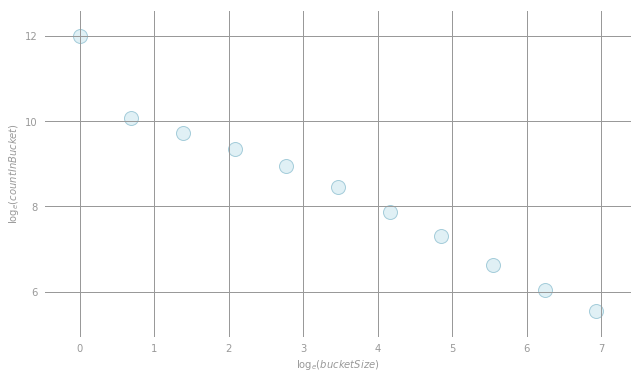

In [34]:
import matplotlib.pyplot as plt

x, y = zip(*featCountsBuckets)
x, y = np.log(x), np.log(y)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(4, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

plt.show()

#### **(3e) Atributos não observados **

#### Naturalmente precisaremos aplicar esse mesmo procedimento para as outras bases (validação e teste), porém nessas bases podem existir atributos não observados na base de treino.

#### Precisamos adaptar a função `oneHotEncoding` para ignorar os atributos que não existem no dicionário.

In [35]:
# EXERCICIO
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
     
    tupla = []
    for (id, valor) in rawFeats:
        try:
            tupla.append((OHEDict[(id, valor)],1))
        except KeyError:
            pass
    return SparseVector(numOHEFeats, tupla)

OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)

[LabeledPoint(0.0, (233286,[7625,9240,15574,21625,31271,36195,36594,39556,49223,61809,66612,67236,68226,68324,73071,76697,81359,81424,92029,96960,98480,109688,117014,121554,141687,146476,147631,171119,184138,184692,185500,185862,194770,198546,201065,210750,213614,222181,227720],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [36]:
# TEST Handling unseen features (3e)
numNZVal = (OHEValidationData
            .map(lambda lp: len(lp.features.indices))
            .sum())
Test.assertEquals(numNZVal, 372080, 'incorrect number of features')

1 test passed.


### ** Part 4: Predição do CTR e avaliação da perda-log (logloss) **

#### ** (4a) Regressão Logística **

#### Um classificador que podemos utilizar nessa base de dados é a regressão logística, que nos dá a probabilidade de um evento de clique em banner ocorrer. Vamos utilizar a função  [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) para treinar um modelo usando  `OHETrainData` com a configuração de parâmetros dada.  `LogisticRegressionWithSGD` retorna um [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  

#### Em seguida, imprima  `LogisticRegressionModel.weights` e `LogisticRegressionModel.intercept` para verificar o modelo gerado. 

In [37]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [38]:
# EXERCICIO
model0 = LogisticRegressionWithSGD.train(OHETrainData,iterations=numIters,step=stepSize,regParam=regParam, regType=regType,intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

C:\opt\spark\spark-2.2.0-bin-hadoop2.7\python\pyspark\mllib\classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


[-0.45899236853575598, -0.3797370764862395, -0.36996558266753304, -0.36934962879928274, -0.32697945415010632] 0.56455084025


In [39]:
# TEST Logistic regression (4a)
Test.assertTrue(np.allclose(model0.intercept,  0.56455084025), 'incorrect value for model0.intercept')
Test.assertTrue(np.allclose(sortedWeights[0:5],
                [-0.45899236853575609, -0.37973707648623956, -0.36996558266753304,
                 -0.36934962879928263, -0.32697945415010637]), 'incorrect value for model0.weights')

1 test passed.
1 test passed.


#### ** (4b) Log loss **

#### Uma forma de avaliar um classificador binário é através do log-loss, definido como: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ onde $ \scriptsize p$ é uma probabilidade entre 0 e 1 e  $ \scriptsize y$ é o rótulo binário (0 ou 1). Log loss é um critério de avaliação muito utilizado quando deseja-se predizer eventos raros. Escreva uma função para calcular o log-loss, e avalie algumas entradas de amostra.

In [40]:
# EXERCICIO
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        p += epsilon
    elif p == 1:
        p -= epsilon
    if y == 1:
        return -log(p)
    else:
        return -log(1 - p)

print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718056
0.69314718056
0.0100503358535
4.60517018599
4.60517018599
0.0100503358535
25.3284360229
1.00000008275e-11
25.3284359402


In [41]:
# TEST Log loss (4b)
Test.assertTrue(np.allclose([computeLogLoss(.5, 1), computeLogLoss(.01, 0), computeLogLoss(.01, 1)],
                            [0.69314718056, 0.0100503358535, 4.60517018599]),
                'computeLogLoss is not correct')
Test.assertTrue(np.allclose([computeLogLoss(0, 1), computeLogLoss(1, 1), computeLogLoss(1, 0)],
                            [25.3284360229, 1.00000008275e-11, 25.3284360229]),
                'computeLogLoss needs to bound p away from 0 and 1 by epsilon')

1 test passed.
1 test passed.


#### ** (4c)  Baseline log loss **

#### Agora, vamos utilizar a função da Parte (4b) para calcular um baseline da métrica de log-loss na nossa base de treino. Uma forma de calcular um baseline é predizer sempre a média dos rótulos observados. Primeiro calcule a média dos rótulos da base e, em seguida, calcule o log-loss médio para a base de treino.

In [42]:
# EXERCICIO
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower
classOneFracTrain = OHETrainData.map(lambda x: x.label).mean()
print classOneFracTrain

logLossTrBase = OHETrainData.map(lambda x: computeLogLoss(classOneFracTrain, x.label)).mean()
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.22717773523
Baseline Train Logloss = 0.536



In [43]:
# TEST Baseline log loss (4c)
Test.assertTrue(np.allclose(classOneFracTrain, 0.22717773523), 'incorrect value for classOneFracTrain')
Test.assertTrue(np.allclose(logLossTrBase, 0.535844), 'incorrect value for logLossTrBase')

1 test passed.
1 test passed.


#### ** (4d) Probabilidade da Predição **

#### O modelo gerado na Parte (4a) possui um método chamado `predict`, porém esse método retorna apenas 0's e 1's. Para calcular a probabilidade de um evento, vamos criar uma função `getP` que recebe como parâmetro o ponto x, o conjunto de pesos `w` e o `intercept`.

#### Calcule o modelo de regressão linear nesse ponto x e aplique a  [função sigmoidal](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ para retornar a probabilidade da predição do objeto x.



In [44]:
# EXERCICIO
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    # calculate rawPrediction = w.x + intercept
    rawPrediction = w.dot(x) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # calculate (1+e^-rawPrediction)^-1
    return 1/(1 + exp(-rawPrediction))

trainingPredictions = OHETrainData.map(lambda x: getP(x.features, model0.weights, model0.intercept))

print trainingPredictions.take(5)

[0.3026288202391113, 0.10362661997434088, 0.283634247838756, 0.1784610205788012, 0.5389775379218853]


In [45]:
# TEST Predicted probability (4d)
Test.assertTrue(np.allclose(trainingPredictions.sum(), 18135.4834348),
                'incorrect value for trainingPredictions')

1 test passed.


#### ** (4e) Avalie o modelo **

#### Finalmente, crie uma função `evaluateResults` que calcula o log-loss médio do modelo em uma base de dados. Em seguida, execute essa função na nossa base de treino.

In [46]:
# EXERCICIO
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    return (data
            .map(lambda x: (x.label, getP(x.features, model.weights, model.intercept)))
            .map(lambda (label, prediction): computeLogLoss(prediction, label))
            .mean()
            )

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

OHE Features Train Logloss:
	Baseline = 0.536
	LogReg = 0.457


In [47]:
# TEST Evaluate the model (4e)
Test.assertTrue(np.allclose(logLossTrLR0, 0.456903), 'incorrect value for logLossTrLR0')

1 test passed.


#### ** (4f) log-loss da validação **

#### Agora aplique o modelo na nossa base de validação e calcule o log-loss médio, compare com o nosso baseline.

In [48]:
# EXERCICIO
logLossValBase = OHEValidationData.map(lambda x: computeLogLoss(classOneFracTrain, x.label)).mean()

logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.457


In [49]:
# TEST Validation log loss (4f)
Test.assertTrue(np.allclose(logLossValBase, 0.527603), 'incorrect value for logLossValBase')
Test.assertTrue(np.allclose(logLossValLR0, 0.456957), 'incorrect value for logLossValLR0')

1 test passed.
1 test passed.


#### **Visualização 2: Curva ROC  **

#### A curva ROC nos mostra o custo-benefício entre a taxa de falso positivo e a taxa de verdadeiro positivo, conforme diminuimos o limiar de predição. Um modelo aleatório é representado por uma linha pontilhada. Idealmente nosso modelo deve formar uma curva acima dessa linha.

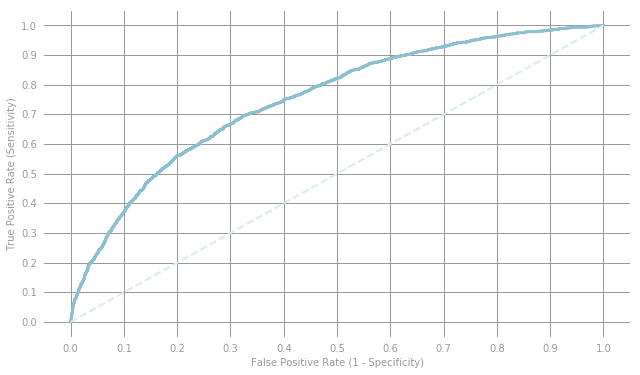

In [50]:
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

plt.show()

### **Parte 5: Reduzindo a dimensão dos atributos via feature hashing**

#### ** (5a) Função Hash **

#### Nosso modelo OHE consegue criar uma representação numérica boa o suficiente para ser aplicável em algoritmos de classificação que não conseguem tratar dados categóricos. Porém, para nossa base de dados isso gerou um número enorme de atributos (233 mil) que pode tornar o problema intratável. Para reduzir o espaço de atributos vamos utilizar um truque através de funções hash chamado de feature hashing.

#### Logo abaixo, já está implementada a função de hash que usaremos nessa parte do notebook. Vamos aplicá-la na nossa base artificial criada na Parte (1a) para termos uma intuição do que está acontecendo. Execute essa função para valores diferentes de `numBuckets` e observe o resultado.

In [51]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

# Reminder of the sample values:
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [52]:
# EXERCICIO
# Use four buckets
sampOneFourBuckets = hashFunction(4, sampleOne, True)
sampTwoFourBuckets = hashFunction(4, sampleTwo, True)
sampThreeFourBuckets = hashFunction(4, sampleThree, True)

# Use one hundred buckets
sampOneHundredBuckets = hashFunction(100, sampleOne, True)
sampTwoHundredBuckets =  hashFunction(100, sampleTwo, True)
sampThreeHundredBuckets =  hashFunction(100, sampleThree, True)

print '\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t {1}'.format(sampOneFourBuckets, sampOneHundredBuckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(sampTwoFourBuckets, sampTwoHundredBuckets)
print 'SampleThree:\t {0}\t {1}'.format(sampThreeFourBuckets, sampThreeHundredBuckets)

{'black1': 2, 'mouse0': 3}
{'cat0': 0, 'tabby1': 0, 'mouse2': 2}
{'bear0': 0, 'black1': 2, 'salmon2': 1}
{'black1': 14, 'mouse0': 31}
{'cat0': 40, 'tabby1': 16, 'mouse2': 62}
{'bear0': 72, 'black1': 14, 'salmon2': 5}
		 4 Buckets 			 100 Buckets
SampleOne:	 {2: 1.0, 3: 1.0}		 {14: 1.0, 31: 1.0}
SampleTwo:	 {0: 2.0, 2: 1.0}		 {40: 1.0, 16: 1.0, 62: 1.0}
SampleThree:	 {0: 1.0, 1: 1.0, 2: 1.0}	 {72: 1.0, 5: 1.0, 14: 1.0}


In [53]:
# TEST Hash function (5a)
Test.assertEquals(sampOneFourBuckets, {2: 1.0, 3: 1.0}, 'incorrect value for sampOneFourBuckets')
Test.assertEquals(sampThreeHundredBuckets, {72: 1.0, 5: 1.0, 14: 1.0},
                  'incorrect value for sampThreeHundredBuckets')

1 test passed.
1 test passed.


#### ** (5b) Criando hashed features **

#### Agora vamos usar essa função hash para criar hashed features para nossa base CTR. Primeiro escreva uma função que usa a função hash da Parte (5a) com numBuckets = $ \scriptsize 2^{15} \approx 33K $ para criar um `LabeledPoint` com os  hashed features armazenados como um `SparseVector`.  Então use esta função para criar uma nova base de treino, validação e teste com  hashed features. Dica: `parsedHashPoint` é similar a `parseOHEPoint` da Parte (3d).

In [54]:
# EXERCICIO
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
        
    palavra = point.split(',')
    texto = palavra[0]
    feat = parsePoint(point)
    return LabeledPoint(texto, SparseVector(numBuckets, hashFunction(numBuckets, feat)))


numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x,numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x,numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda x: parseHashPoint(x,numBucketsCTR))
hashTestData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [55]:
# TEST Creating hashed features (5b)
hashTrainDataFeatureSum = sum(hashTrainData
                           .map(lambda lp: len(lp.features.indices))
                           .take(20))
hashTrainDataLabelSum = sum(hashTrainData
                         .map(lambda lp: lp.label)
                         .take(100))
hashValidationDataFeatureSum = sum(hashValidationData
                                .map(lambda lp: len(lp.features.indices))
                                .take(20))
hashValidationDataLabelSum = sum(hashValidationData
                              .map(lambda lp: lp.label)
                              .take(100))
hashTestDataFeatureSum = sum(hashTestData
                          .map(lambda lp: len(lp.features.indices))
                          .take(20))
hashTestDataLabelSum = sum(hashTestData
                        .map(lambda lp: lp.label)
                        .take(100))

Test.assertEquals(hashTrainDataFeatureSum, 772, 'incorrect number of features in hashTrainData')
Test.assertEquals(hashTrainDataLabelSum, 24.0, 'incorrect labels in hashTrainData')
Test.assertEquals(hashValidationDataFeatureSum, 776,
                  'incorrect number of features in hashValidationData')
Test.assertEquals(hashValidationDataLabelSum, 16.0, 'incorrect labels in hashValidationData')
Test.assertEquals(hashTestDataFeatureSum, 774, 'incorrect number of features in hashTestData')
Test.assertEquals(hashTestDataLabelSum, 23.0, 'incorrect labels in hashTestData')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (5c) Esparsidade **

#### Uma vez que temos  33 mil hashed features contra 233 mil OHE, devemos esperar que os atributos OHE sejam mais esparsos. Verifique essa hipótese computando a esparsidade média do OHE e do hashed features.

#### Note que se você tem um `SparseVector` chamado `sparse`, chamar `len(sparse)` retornará o total de atributos, e não o número de valores não nulos. `SparseVector` tem atributos `indices` e `values` que contém informações sobre quais atributos são não nulos. 

In [56]:
# EXERCICIO
def computeSparsity(data, d, n):
    """Calculates the average sparsity for the features in an RDD of LabeledPoints.

    Args:
        data (RDD of LabeledPoint): The LabeledPoints to use in the sparsity calculation.
        d (int): The total number of features.
        n (int): The number of observations in the RDD.

    Returns:
        float: The average of the ratio of features in a point to total features.
    """
    return (data
            .map(lambda x: len(x.features.indices))
            .mean()
            )/d

averageSparsityHash = computeSparsity(hashTrainData, numBucketsCTR, nTrain)
averageSparsityOHE = computeSparsity(OHETrainData, numCtrOHEFeats, nTrain)

print 'Average OHE Sparsity: {0:.7e}'.format(averageSparsityOHE)
print 'Average Hash Sparsity: {0:.7e}'.format(averageSparsityHash)

Average OHE Sparsity: 1.6717677e-04
Average Hash Sparsity: 1.1805561e-03


In [57]:
# TEST Sparsity (5c)
Test.assertTrue(np.allclose(averageSparsityOHE, 1.6717677e-04),
                'incorrect value for averageSparsityOHE')
Test.assertTrue(np.allclose(averageSparsityHash, 1.1805561e-03),
                'incorrect value for averageSparsityHash')

1 test passed.
1 test passed.


#### ** (5d) Modelo logístico com hashed features **

#### Agora treine um modelo de regressão logística para os hashed features. Execute um grid search para encontrar parâmetros adequados para essa base, avaliando o log-loss no conjunto de validação. Nota: isso pode demorar alguns minutos para terminar. Use `stepSizes` de 1 e 10 e `regParams`  de 1e-6 e 1e-3.

In [58]:
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [67]:
# EXERCICIO
stepSizes = [1, 10]
regParams = [1e-6, 1e-3]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 1.0, regParam = 1e-06: logloss = 0.475
	stepSize = 1.0, regParam = 1e-03: logloss = 0.475
	stepSize = 10.0, regParam = 1e-06: logloss = 0.450
	stepSize = 10.0, regParam = 1e-03: logloss = 0.452
Hashed Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.450


In [68]:
# TEST Logistic model with hashed features (5d)
Test.assertTrue(np.allclose(bestLogLoss, 0.4481683608), 'incorrect value for bestLogLoss')

1 test failed. incorrect value for bestLogLoss


#### ** (5e) Avaliando a base de testes **

#### Finalmente, avalie o melhor modelo da Parte (5d) na base de testes. Compare o log-loss do resultado com o log-loss do nosso baseline no conjunto de testes, calculando da mesma forma que na Parte (4f).

In [74]:
# EXERCICIO
# Log loss for the best model from (5d)
logLossValLR0 = evaluateResults(model0, OHEValidationData)

logLossTest = evaluateResults(bestModel, hashTestData)

# Log loss for the baseline model
logLossTestBaseline = hashTestData.map(lambda lp: computeLogLoss(classOneFracTrain,lp.label)).mean()

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTestBaseline, logLossTest))

Hashed Features Test Log Loss:
	Baseline = 0.537
	LogReg = 0.457


In [75]:
# TEST Evaluate on the test set (5e)
Test.assertTrue(np.allclose(logLossTestBaseline, 0.537438),
                'incorrect value for logLossTestBaseline')
Test.assertTrue(np.allclose(logLossTest, 0.455616931), 'incorrect value for logLossTest')

1 test passed.
1 test failed. incorrect value for logLossTest
